# Question-Answer Validation: Machine Learning vs Deep Learning

[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/alvaro-francisco-gil/nn4nlp/blob/main/exercises/04_transformers_and_contextuals.ipynb) 
[![View on GitHub](https://img.shields.io/badge/Open%20on-GitHub-blue?logo=github)](https://github.com/alvaro-francisco-gil/nn4nlp/blob/main/exercises/04_transformers_and_contextuals.ipynb)



The task of this experiment is to measure how much of the truthfulness of a question-answer pair can be inferred using both machine learning and deep learning approaches

## Imports

If you are running this notebook in Google Colab, you can install the required packages by running the following cell:


In [1]:
# !pip install torch transformers pandas numpy seaborn matplotlib

In [2]:
import re
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from torch.optim import AdamW
from sklearn.metrics import f1_score
import time
import seaborn as sns
import gensim
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from gensim.models import Word2Vec
from sklearn.metrics import accuracy_score, classification_report
from tqdm import tqdm
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from collections import Counter
from datasets import load_dataset

import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from transformers import (
    BertForSequenceClassification,
    XLNetForSequenceClassification,
    get_linear_schedule_with_warmup,
    AutoTokenizer
)

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Using device: cuda


## Dataset Preparation

In [3]:
boolq = load_dataset("boolq")

print(f"Available splits: {boolq.keys()}")
print(f"Training set size: {boolq['train'].shape}")
print(f"Validation set size: {boolq['validation'].shape}")

print("\nExample data point:")
boolq["train"][0]

Available splits: dict_keys(['train', 'validation'])
Training set size: (9427, 3)
Validation set size: (3270, 3)

Example data point:


{'question': 'do iran and afghanistan speak the same language',
 'answer': True,
 'passage': 'Persian (/ˈpɜːrʒən, -ʃən/), also known by its endonym Farsi (فارسی fārsi (fɒːɾˈsiː) ( listen)), is one of the Western Iranian languages within the Indo-Iranian branch of the Indo-European language family. It is primarily spoken in Iran, Afghanistan (officially known as Dari since 1958), and Tajikistan (officially known as Tajiki since the Soviet era), and some other regions which historically were Persianate societies and considered part of Greater Iran. It is written in the Persian alphabet, a modified variant of the Arabic script, which itself evolved from the Aramaic alphabet.'}

For this task, we chose the dataset boolq, which is a dataset of boolean questions and answers. As our aim is not directly answering the question, but evaluating wether the answer of a question is correct, we first need to transform the dataset into a question-answer format. For this, we divide each datapoint into two, the correct question-answer pair and the incorrect one.

In [4]:
# Create new training and validation datasets with correct and incorrect question-answer pairs
new_train_data = []
new_validation_data = []

# Process training data
for example in boolq["train"]:
    # Create correct pair
    correct_pair = {
        "text": f"The question is '{example['question']}' and the answer is '{example['answer']}'",
        "label": "correct"
    }
    new_train_data.append(correct_pair)
    
    # Create incorrect pair
    incorrect_pair = {
        "text": f"The question is '{example['question']}' and the answer is '{not example['answer']}'",
        "label": "incorrect"
    }
    new_train_data.append(incorrect_pair)

# Process validation data
for example in boolq["validation"]:
    # Create correct pair
    correct_pair = {
        "text": f"The question is '{example['question']}' and the answer is '{example['answer']}'",
        "label": "correct"
    }
    new_validation_data.append(correct_pair)
    
    # Create incorrect pair
    incorrect_pair = {
        "text": f"The question is '{example['question']}' and the answer is '{not example['answer']}'",
        "label": "incorrect"
    }
    new_validation_data.append(incorrect_pair)

print("Training examples:")
print(new_train_data[0])
print(new_train_data[1])
print("\nValidation examples:")
print(new_validation_data[0])
print(new_validation_data[1])

Training examples:
{'text': "The question is 'do iran and afghanistan speak the same language' and the answer is 'True'", 'label': 'correct'}
{'text': "The question is 'do iran and afghanistan speak the same language' and the answer is 'False'", 'label': 'incorrect'}

Validation examples:
{'text': "The question is 'does ethanol take more energy make that produces' and the answer is 'False'", 'label': 'correct'}
{'text': "The question is 'does ethanol take more energy make that produces' and the answer is 'True'", 'label': 'incorrect'}


In [5]:
len(new_train_data)

18854

By composition, the dataset will be perfectly balanced, with 50% of the data being correct and 50% being incorrect.

Separate x and y

In [6]:
X_train = [example['text'] for example in new_train_data]
y_train = [example['label'] for example in new_train_data]

X_validation = [example['text'] for example in new_validation_data]
y_validation = [example['label'] for example in new_validation_data]

print(X_train[0])
print(y_train[0])


The question is 'do iran and afghanistan speak the same language' and the answer is 'True'
correct


Let's encode the labels

In [7]:
y_train = [1 if label == 'correct' else 0 for label in y_train]
y_validation = [1 if label == 'correct' else 0 for label in y_validation]

print(y_train[0])
print(y_validation[0])

1
1


## Machine Learning Approach

### Pre-processing

Question: What should we do with stopwords and numbers?

Experiment: Look at the data

In [8]:
# Get X_train data containing numbers
X_train_with_numbers = [text for text in X_train if any(c.isdigit() for c in text)]
print(X_train_with_numbers[0])
print(X_train_with_numbers[3])
print(X_train_with_numbers[10])


The question is 'will there be a season 4 of da vinci's demons' and the answer is 'False'
The question is 'will there be a green lantern 2 movie' and the answer is 'True'
The question is 'is it legal to own an ar15 in california' and the answer is 'False'


It seems that the numbers are meaningful to be able to answer the questions, so we should not remove them.

In [9]:
# Get English stopwords
stop_words = set(stopwords.words('english'))

def remove_stopwords(text):
    # Split text into words
    words = text.split()
    # Filter out stopwords
    filtered_words = [word for word in words if word.lower() not in stop_words]
    return ' '.join(filtered_words)

# Apply stopword removal to the data
X_train_without_stopwords = [remove_stopwords(text) for text in X_train]
X_validation_without_stopwords = [remove_stopwords(text) for text in X_validation]

print(X_train[0])
print(X_train_without_stopwords[0])


The question is 'do iran and afghanistan speak the same language' and the answer is 'True'
question 'do iran afghanistan speak language' answer 'True'


In this case, the word "same" is being removed, so we should not remove the full list of stopwords, as they can contain valuable information.

Conclusion: The preprocessing should be: Downcase, remove punctuation, and remove stopwords that are not meaningful.

In [10]:
def preprocess_text(text):
    # Convert to lowercase
    text = text.lower()
    
    # Remove punctuation
    text = re.sub(r'[^\w\s]', '', text)
    
    # Remove extra whitespace
    text = ' '.join(text.split())
    
    # Remove only common stopwords that are less meaningful
    common_stopwords = {'the', 'a', 'an', 'and', 'or', 'but', 'is', 'are', 'was', 'were'}
    words = text.split()
    filtered_words = [word for word in words if word not in common_stopwords]
    
    return ' '.join(filtered_words)

# Apply preprocessing to the data
X_train_preprocessed = [preprocess_text(text) for text in X_train]
X_validation_preprocessed = [preprocess_text(text) for text in X_validation]

print(X_train_preprocessed[0])


question do iran afghanistan speak same language answer true


### Encoding

As the semantical meaning of the words is important, we will use word2vec to encode the data.

In [11]:
# Tokenize the text data
X_train_tokens = [text.split() for text in X_train_preprocessed]
X_validation_tokens = [text.split() for text in X_validation_preprocessed]

# Train Word2Vec model
word2vec_model = Word2Vec(
    sentences=X_train_tokens,
    vector_size=100,  # Size of word vectors
    window=5,         # Context window size
    min_count=2,      # Minimum word frequency
    workers=4,        # Number of worker threads
    sg=1             # Skip-gram model
)

# Function to get document vector by averaging word vectors
def get_document_vector(tokens, model):
    vectors = []
    for token in tokens:
        if token in model.wv:
            vectors.append(model.wv[token])
    if vectors:
        return np.mean(vectors, axis=0)
    else:
        return np.zeros(model.vector_size)

# Convert documents to vectors
X_train_encoded = np.array([get_document_vector(doc, word2vec_model) for doc in X_train_tokens])
X_validation_encoded = np.array([get_document_vector(doc, word2vec_model) for doc in X_validation_tokens])

print(f"Training data shape: {X_train_encoded.shape}")
print(f"Validation data shape: {X_validation_encoded.shape}")


Training data shape: (18854, 100)
Validation data shape: (6540, 100)


### Model Training

In [12]:
def train_and_evaluate_models(X_train, y_train, X_val, y_val):
    # Define models and their parameter grids
    models = {
        'Random Forest': {
            'model': RandomForestClassifier(random_state=42),
            'params': {
                'n_estimators': [100, 200],
                'max_depth': [None, 10]
            }
        },
        'SVM': {
            'model': SVC(random_state=42),
            'params': {
                'C': [0.1, 1],
                'kernel': ['linear', 'rbf']
            }
        },
        'Logistic Regression': {
            'model': LogisticRegression(random_state=42, max_iter=1000, solver='liblinear'),
            'params': {
                'C': [0.1, 1],
                'penalty': ['l1', 'l2']
            }
        }
    }

    # Perform grid search for each model
    best_models = {}
    results = []

    for model_name, model_info in models.items():
        print(f"\nTraining {model_name}...")
        grid_search = GridSearchCV(
            estimator=model_info['model'],
            param_grid=model_info['params'],
            cv=5,
            scoring='accuracy',
            n_jobs=-1
        )
        
        grid_search.fit(X_train, y_train)
        best_models[model_name] = grid_search.best_estimator_
        
        # Get predictions and metrics
        y_pred = grid_search.predict(X_val)
        val_accuracy = accuracy_score(y_val, y_pred)
        report = classification_report(y_val, y_pred, output_dict=True)
        
        # Store results for visualization
        results.append({
            'model': model_name,
            'best_params': grid_search.best_params_,
            'best_score': grid_search.best_score_,
            'val_accuracy': val_accuracy,
            'precision': report['weighted avg']['precision'],
            'recall': report['weighted avg']['recall'],
            'f1': report['weighted avg']['f1-score']
        })

    # Convert results to DataFrame for visualization
    results_df = pd.DataFrame(results)
    return best_models, results_df

In [13]:
best_models, results_df = train_and_evaluate_models(X_train_encoded, y_train, X_validation_encoded, y_validation)


Training Random Forest...

Training SVM...

Training Logistic Regression...


### Results Visualization

In [14]:
def visualize_model_results(results_df):
    """
    Visualize model comparison results and print best model metrics.
    
    Args:
        results_df (pd.DataFrame): DataFrame containing model results
    """
    # Create visualizations
    plt.figure(figsize=(15, 5))

    # Plot 1: Model Comparison
    plt.subplot(1, 3, 1)
    ax1 = sns.barplot(data=results_df, x='model', y='val_accuracy')
    plt.title('Model Validation Accuracy')
    plt.xticks(rotation=45)
    plt.ylim(0.5, 0.65)
    # Add value labels on top of bars
    for p in ax1.patches:
        ax1.annotate(f'{p.get_height():.3f}', 
                    (p.get_x() + p.get_width()/2., p.get_height()),
                    ha='center', va='bottom')

    # Plot 2: Precision and Recall
    plt.subplot(1, 3, 2)
    metrics_df = results_df.melt(id_vars=['model'], 
                               value_vars=['precision', 'recall'],
                               var_name='metric', value_name='score')
    ax2 = sns.barplot(data=metrics_df, x='model', y='score', hue='metric')
    plt.title('Precision and Recall by Model')
    plt.xticks(rotation=45)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    # Add value labels on top of bars
    for p in ax2.patches:
        ax2.annotate(f'{p.get_height():.2f}', 
                    (p.get_x() + p.get_width()/2., p.get_height()),
                    ha='center', va='bottom')

    # Plot 3: F1 Scores
    plt.subplot(1, 3, 3)
    ax3 = sns.barplot(data=results_df, x='model', y='f1')
    plt.title('F1 Scores by Model')
    plt.xticks(rotation=45)
    # Add value labels on top of bars
    for p in ax3.patches:
        ax3.annotate(f'{p.get_height():.2f}', 
                    (p.get_x() + p.get_width()/2., p.get_height()),
                    ha='center', va='bottom')

    plt.tight_layout()
    plt.show()

    # Find the best performing model
    best_model = results_df.loc[results_df['val_accuracy'].idxmax()]
    print(f"\nBest overall model: {best_model['model']}")
    print(f"Best model accuracy: {best_model['val_accuracy']:.4f}")
    print(f"Best model precision: {best_model['precision']:.4f}")

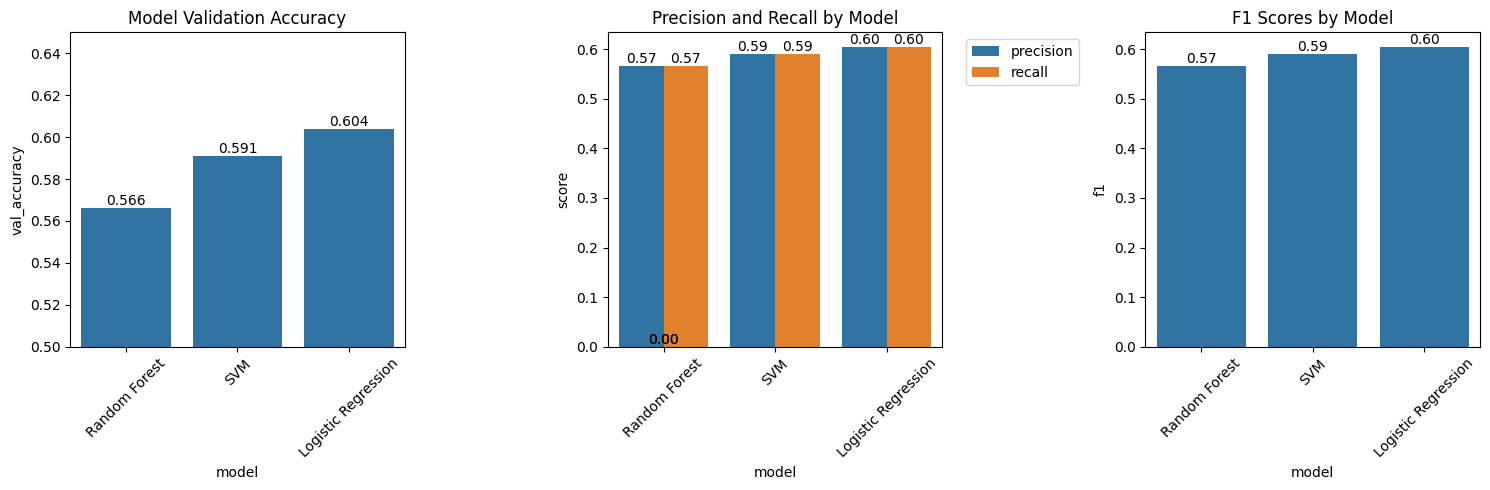


Best overall model: Logistic Regression
Best model accuracy: 0.6037
Best model precision: 0.6037


In [15]:
visualize_model_results(results_df)

The results of 0.6 accuracy are relatively low, given that the baseline is 0.5 accuracy. However, they are still higher than one might expect—especially when we reflect on the nature of the task we are trying to solve with this approach.

In essence, this task is a general knowledge evaluation. To determine whether a question–answer pair is correct, one would typically need access to factual knowledge. While this kind of evaluation is common for general pretrained models, which have been exposed to large corpora, it's more surprising for models trained only on limited labeled datasets.

What makes this setup intriguing is that models still perform better than random guessing on factual correctness judgments, even without explicit external knowledge. There are a couple of strong hypotheses for why this might happen:

1. **Implicit Knowledge in Word Embeddings**: Pretrained embeddings like Word2Vec can encode rich semantic relationships based on co-occurrence statistics in large corpora. This allows models to make informed judgments based on the geometry of the embeddings, even without direct supervision on the facts.

2. **Data Leakage or Memorization**: The dataset may inadvertently allow information to leak from the training to the validation/test splits. If similar questions, phrasings, or facts are repeated, the model may learn to associate certain patterns with correctness labels.

While it’s sometimes suggested that models might exploit superficial statistical cues (e.g., answers that “sound more right”), the specific format of this task—where both the correct and incorrect answers to a question are given in similar wording—makes this unlikely. The model isn't deciding between alternatives based on plausibility; it's classifying whether a specific question–answer pair is factually correct, which requires deeper reasoning or memorization.








## Machine Learning Approach with BERT tokenizer

Before passing to the pretrained models, let's explore how much could we get out of the ml models, now using the BERT tokenizer.

In this case, no preprocessing is required since the BERT tokenizer will handle the preprocessing tasks.

In [16]:
# Initialize BERT tokenizer
bert_tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')

# Function to tokenize text data and convert to numpy arrays for ML models
def tokenize_bert_for_ml(texts):
    encodings = bert_tokenizer(
        texts, 
        truncation=True, 
        padding='max_length', 
        max_length=128,
        return_tensors='pt'
    )
    # Convert to numpy arrays and combine input_ids and attention_mask
    input_ids = encodings['input_ids'].numpy()
    attention_mask = encodings['attention_mask'].numpy()
    # Combine features into a single array
    return np.concatenate([input_ids, attention_mask], axis=1)

# Tokenize training and validation data
X_train_bert = tokenize_bert_for_ml(X_train)
X_val_bert = tokenize_bert_for_ml(X_validation)

print(X_train_bert.shape)
print(X_val_bert.shape)

/opt/conda/lib/python3.11/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


(18854, 256)
(6540, 256)


In [ ]:
best_models, results_df = train_and_evaluate_models(X_train_bert, y_train, X_val_bert, y_validation)


Training Random Forest...

Training SVM...


In [ ]:
visualize_model_results(results_df)

## Deep Learning Approach

In [ ]:
def train_and_evaluate_bert(X_train, y_train, X_validation, y_validation, epochs=10, batch_size=16, train_bert=True):
    """
    Train and evaluate a BERT model for sequence classification.
    
    Args:
        X_train (list): Training text data
        y_train (array): Training labels
        X_validation (list): Validation text data
        y_validation (array): Validation labels
        epochs (int): Number of training epochs
        batch_size (int): Batch size for training
        train_bert (bool): Whether to train the BERT base model or just the classification head
        
    Returns:
        tuple: (model, training_stats)
    """
    # Initialize BERT tokenizer
    bert_tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')
    
    # Encode the text data
    train_encodings = bert_tokenizer(
        X_train.tolist(),
        truncation=True,
        padding='max_length',
        max_length=128,
        return_tensors='pt'
    )

    val_encodings = bert_tokenizer(
        X_validation.tolist(),
        truncation=True,
        padding='max_length',
        max_length=128,
        return_tensors='pt'
    )

    # Create PyTorch dataset class
    class QADataset(torch.utils.data.Dataset):
        def __init__(self, encodings, labels):
            self.encodings = encodings
            self.labels = labels

        def __getitem__(self, idx):
            item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
            item['labels'] = torch.tensor(self.labels[idx])
            return item

        def __len__(self):
            return len(self.labels)

    # Create datasets
    train_dataset = QADataset(train_encodings, y_train)
    val_dataset = QADataset(val_encodings, y_validation)

    # Create data loaders
    train_dataloader = torch.utils.data.DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=True
    )

    val_dataloader = torch.utils.data.DataLoader(
        val_dataset,
        batch_size=batch_size,
        shuffle=False
    )

    # Initialize the model
    model = BertForSequenceClassification.from_pretrained(
        'bert-base-uncased',
        num_labels=2
    ).to(device)

    # Freeze BERT parameters if not training the full model
    if not train_bert:
        for param in model.bert.parameters():
            param.requires_grad = False

    # Initialize optimizer and scheduler
    optimizer = AdamW(model.parameters(), lr=2e-5, eps=1e-8)
    total_steps = len(train_dataloader) * epochs
    scheduler = get_linear_schedule_with_warmup(
        optimizer, num_warmup_steps=0, num_training_steps=total_steps
    )

    # Training loop
    training_stats = []
    total_training_time = 0

    for epoch in range(epochs):
        print(f'\nEpoch {epoch + 1}/{epochs}')
        print('-' * 10)

        # Training phase
        model.train()
        total_train_loss = 0
        train_start_time = time.time()

        for batch in train_dataloader:
            # Move batch to device
            batch = {k: v.to(device) for k, v in batch.items()}
            
            # Forward pass
            outputs = model(**batch)
            loss = outputs.loss
            
            # Backward pass
            loss.backward()
            optimizer.step()
            scheduler.step()
            optimizer.zero_grad()
            
            total_train_loss += loss.item()

        # Calculate average training loss
        avg_train_loss = total_train_loss / len(train_dataloader)
        train_time = time.time() - train_start_time
        total_training_time += train_time

        # Validation phase
        model.eval()
        total_val_loss = 0
        val_predictions = []
        val_true_labels = []

        with torch.no_grad():
            for batch in val_dataloader:
                batch = {k: v.to(device) for k, v in batch.items()}
                outputs = model(**batch)
                loss = outputs.loss
                total_val_loss += loss.item()
                
                # Get predictions
                logits = outputs.logits
                predictions = torch.argmax(logits, dim=1)
                val_predictions.extend(predictions.cpu().numpy())
                val_true_labels.extend(batch['labels'].cpu().numpy())

        # Calculate validation metrics
        avg_val_loss = total_val_loss / len(val_dataloader)
        val_accuracy = accuracy_score(val_true_labels, val_predictions)
        val_f1 = f1_score(val_true_labels, val_predictions)

        # Store statistics
        epoch_stats = {
            'epoch': epoch + 1,
            'train_loss': avg_train_loss,
            'val_loss': avg_val_loss,
            'val_accuracy': val_accuracy,
            'val_f1': val_f1,
            'train_time': train_time
        }
        training_stats.append(epoch_stats)

        print(f'Training Loss: {avg_train_loss:.4f}')
        print(f'Validation Loss: {avg_val_loss:.4f}')
        print(f'Validation Accuracy: {val_accuracy:.4f}')
        print(f'Validation F1: {val_f1:.4f}')
        print(f'Training Time: {train_time:.2f}s')

    print(f'\nTotal Training Time: {total_training_time:.2f}s')
    
    return model, training_stats

model, training_stats = train_and_evaluate_bert(X_train, y_train, X_validation, y_validation, train_bert=False)


Thanks for reading the code, connect with me on [LinkedIn](https://www.linkedin.com/in/alvaro-francisco-gil/) or [GitHub](https://github.com/alvaro-francisco-gil) if you have any questions or comments.

*Álvaro Francisco Gil*